In [1]:
%matplotlib inline
import rootpy.ROOT as R
R.gROOT.SetBatch(True)
from rootpy.io import root_open, DoesNotExist
from rootpy.plotting import Canvas, Hist, Legend
import rootpy.plotting.root2matplotlib as rplt
import matplotlib.pyplot as plt

In [8]:
data = root_open( "/Users/danielbrandenburg/bnl/local/work/rcpMaker/products/PidHisto_wo_elec_eff_K.root" )

zb = data.tof.zb_K_p_0_17
zd = data.dedx.zd_K_p_0_17

def fixBinWidth( h ) :
    for bin in range( 1, h.GetNbinsX()+1 ) :
        bc = h.GetBinContent( bin )
        be = h.GetBinError( bin )
        bw = h.GetBinWidth( bin )
        h.SetBinContent( bin, bc / bw )
        h.SetBinError( bin, be / bw )
fixBinWidth( zb )
fixBinWidth( zd )


def setLimits( f, mus, n, sig ) :
    f.SetParLimits( 1, mus[0] - n * sig, mus[0] + n * sig )
    f.SetParLimits( 4, mus[1] - n * sig, mus[1] + n * sig )
    f.SetParLimits( 7, mus[2] - n * sig, mus[2] + n * sig )
    
    f.SetParLimits( 2, sig * .25, sig * 2 )
    f.SetParLimits( 5, sig * .25, sig )
    f.SetParLimits( 8, sig * .25, sig * 2 )

    
def printPars( f, **kwargs ) :
    if 'title' in kwargs :
        print kwargs[ 'title' ]
    for i in range( 0, f.GetNpar() ) :
        print "p", i , "=", f.GetParameter(i)
        
def singleGauss( f, fp, x1, x2 ) :
    nf = R.TF1( "nf_" + str(fp), "[0] /( [2] * sqrt( 2 * 3.14 ) )* exp( -0.5*((x-[1])^2/(2*[2]^2)))", x1, x2 )
    pars = f.GetParameters()
    nf.SetParameters( pars[ fp ], pars[ fp + 1 ], pars[ fp + 2 ] )
    nf.SetLineWidth(2)
    nf.SetLineColor( R.kBlue )
    return nf

def fixShapes( f ) :
    pars = f.GetParameters()
    f.FixParameter( 1, pars[1] )
    f.FixParameter( 2, pars[2] )
    
    f.FixParameter( 4, pars[4] )
    f.FixParameter( 5, pars[5] )
    
    f.FixParameter( 7, pars[7] )
    f.FixParameter( 8, pars[8] )


In [9]:
r1 = ( -1.1, 0.2 )
r2 = ( -1.5, 0.4 )

In [10]:
fns = "[0] /( [2] * sqrt( 2 * 3.14 ) )* exp( -0.5*((x-[1])^2/(2*[2]^2))) + [3] /( [5] * sqrt( 2 * 3.14 ) )* exp( -0.5*((x-[4])^2/(2*[5]^2))) + [6] /( [8] * sqrt( 2 * 3.14 ) )* exp( -0.5*((x-[7])^2/(2*[8]^2)))"

f = R.TF1( "f", "[0] /( [2] * sqrt( 2 * 3.14 ) )* exp( -0.5*((x-[1])^2/(2*[2]^2)))", -1.5, 1.5 )
f.SetLineWidth(2)
f.SetLineColor( R.kBlue )


f1 = R.TF1( "f1", fns, -1.5, 0.3 )
f1.SetParameters( 1e3, mu1[0], 0.012, 1e2, mu1[1], 0.012, 1e2, mu1[2], 0.012  )
setLimits( f1, mu1, 4, 0.012 )
f1.SetLineColor( R.kRed )
f1.SetLineWidth( 2 )

f1.FixParameter( 3, 0 )

f2 = R.TF1( "f2", fns, -1.5, 0.3 )
f2.SetParameters( 1e3, mu2[0], 0.07, 1e2, mu2[1], 0.07, 1e2, mu2[2], 0.07 )
setLimits( f2, mu2, 2, 0.07 )
f2.SetLineColor( R.kRed )
f2.SetLineWidth( 2 )

f2.FixParameter( 3, 0 )


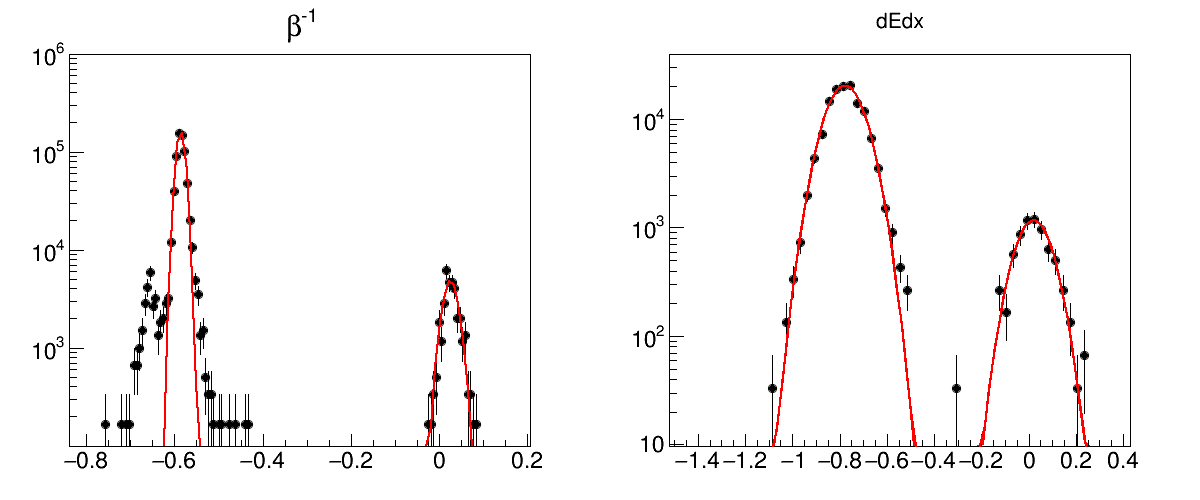

In [11]:
can = Canvas( width=1200, height=500 )
can.Divide( 2, 1 )
can.cd(1)
R.gStyle.SetOptStat( 0 )

################# Zb fit
zb.Fit( f1, "R" )
zb.Fit( f1, "R" )
fixShapes( f1 )
zb.Fit( f1, "RL" )
zb.Draw("pe")
zb.GetXaxis().SetRangeUser( r1[0], r1[1] )
zb.GetYaxis().SetRangeUser( 1e2, 1e6 )
R.gPad.SetLogy(1)

############### Zd Fit
can.cd(2)
R.gStyle.SetOptStat( 0 )
zd.Fit( f2, "R" )
zd.Fit( f2, "R" )
fixShapes( f2 )
zd.Fit( f2, "RL" )

zd.Draw( "pe")
f2.SetRange( -100, 100 )
f2.Draw("same")
zd.GetXaxis().SetRangeUser( r2[0], r2[1] )

felec = singleGauss( f2, 3, r2[0], r2[1] )
felec.Draw("same")

R.gPad.SetLogy(1)
can

In [12]:
mu1 = ( -0.55, -0.68, 0.0 )
mu2 = ( -0.9, -0.25, 0.1 )

In [13]:
def eff( par ) : 
    if ( f2.GetParameter( par ) > 0 ) :
        return f1.GetParameter( par ) / f2.GetParameter( par ) 
    else :
        return 0


print "E_Pi =", eff( 0 )
print "E_elec =", eff(3)
print "E_K =", eff(6)

print "average =", ( eff(0) + eff(3) + eff(6) ) / 2.0

E_Pi = 1.04475626609
E_elec = 0
E_K = 0.995144621702
average = 1.0199504439
